# Анализ убытков приложения ProcrastinatePRO+

**Описание проекта:** 

В наше распоряжение попали данные развлекательного приложения Procrastinate Pro+. Компания вкладывает огромные вложения в рекламу, однако последние несколько месяцев компания терпит убытки. Наша задача — разобраться в причинах и помочь компании выйти в плюс.

Нам предоставлен лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. Нам предстоит изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отрицательно влияют на привлечение пользователей.

## Шаг 1. Обзор данных

Импортируем необходимые библиотеки.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

У нас 3 датафрейма. Для обзора данных воспользуемся методами head(), info() и describe().

In [2]:
visits = pd.read_csv('visits_info_short.csv')
display(visits.head())
visits.info()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [3]:
orders = pd.read_csv('orders_info_short.csv')
display(orders.head())
display(orders.info())
orders.describe()

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


None

,User Id,Revenue
count,4.021200e+04,40212.000000
mean,4.990295e+11,5.370608
std,2.860937e+11,3.454208
min,5.993260e+05,4.990000
25%,2.511324e+11,4.990000
50%,4.982840e+11,4.990000
75%,7.433327e+11,4.990000
max,9.998954e+11,49.990000


In [4]:
costs = pd.read_csv('costs_info_short.csv')
display(costs.head())
display(costs.info())
costs.describe()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


None

,costs
count,1800.000000
mean,58.609611
std,107.740223
min,0.800000
25%,6.495000
50%,12.285000
75%,33.600000
max,630.000000


**Вывод**

В данных встречаются следующие проблем:

* местами указан некорректный тип данных;
* разные регистры в названиях колонок;
* возможно присутствуют дубликаты.

Это только первоначальные наблюдения. Проведем обработку данных, чтобы выявить все аномалии. 

## Шаг 2. Предобработка данных

1. Приведем все названия колонок к нижнему регистру.

In [5]:
visits.columns = visits.columns.str.lower()
visits.rename(columns = {'user id': 'user_id','session start' : 'session_start', 'session end' : 'session_end'}, inplace = True)
visits.columns

Index(['user_id', 'region', 'device', 'channel', 'session_start',
       'session_end'],
      dtype='object')

In [6]:
orders.columns = orders.columns.str.lower()
orders.rename(columns = {'user id' : 'user_id', 'event dt' : 'event_dt'}, inplace = True)
orders.columns

Index(['user_id', 'event_dt', 'revenue'], dtype='object')

In [7]:
costs.columns = costs.columns.str.lower()
costs.columns

Index(['dt', 'channel', 'costs'], dtype='object')

2. Изменим типы данных в необходимых колонках.

In [8]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

In [9]:
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [10]:
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

3. Проверим таблицы на наличие дубликатов.

In [11]:
display(visits.duplicated().sum())
display(orders.duplicated().sum())
costs.duplicated().sum()

0

0

0

Данные подготовлены к анализу.

# Шаг 3. Задать функции для расчета и анализа LTV, ROI, удержания и конверсии

Зададим функции необходимые для дальнейшего анализа:
* get_profiles() - функция для создания пользовательских профилей;
* get_retention() - функция для расчёта удержания;
* get_conversion() - функция для расчёта конверсии;
* get_ltv() - функция для расчёта LTV и ROI; 
* filter_data() - функция для сглаживания фрейма;
* plot_retention() - функция для визуализации удержания;
* plot_conversion() - функция для визуализации конверсии;
* plot_ltv_roi() -  функция для визуализации LTV и ROI.

In [12]:
# функция для создания пользовательских профилей

def get_profiles(visits, orders, costs):

    # находим параметры первых посещений
    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    costs = costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    costs['acquisition_cost'] = costs['costs'] / costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


In [13]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [14]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [15]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [16]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [17]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=14):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [18]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=14):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [19]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=14):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [20]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

# Шаг 4. Исследовательский анализ данных

Построим профили пользователей. Определим минимальную и максимальную дату привлечения пользователей.

Выясним:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

Для начала построим профили пользователей и определим минимальную и максимальную даты привлечения пользователей.

In [21]:
# получаем профили пользователей

profiles = get_profiles(visits, orders, costs)
display(profiles.head())

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [22]:
# определяем минимальную и максимальную дату привлечения пользователей

display(profiles['dt'].min())
display(profiles['dt'].max())

datetime.date(2019, 5, 1)

datetime.date(2019, 10, 27)

Определим из каких стан приходят пользователи приложения, и какие страны дают больше всего платящих пользователей. Для этого построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.

In [23]:
regions = profiles.groupby('region').agg({'user_id': 'nunique' ,'payer': ['sum', 'mean']})
regions.columns = ['user_id_nunique', 'payer_sum', 'payer_mean']
regions.sort_values(by = 'user_id_nunique', ascending = False)

,user_id_nunique,payer_sum,payer_mean
region,,,
United States,100002,6902,0.069019
UK,17575,700,0.039829
France,17450,663,0.037994
Germany,14981,616,0.041119


По конвертации и по количеству пользователей в приоритете Америка. 

Также определим какие устройства используют пользователи для входа в приложение и с каких устройств чаще всего заходят платящие пользователи. 

In [24]:
devices = profiles.groupby('device').agg({'user_id': 'nunique' ,'payer': ['sum', 'mean']})
devices.columns = ['user_id_nunique', 'payer_sum', 'payer_mean']
devices.sort_values(by = 'user_id_nunique', ascending = False)

,user_id_nunique,payer_sum,payer_mean
device,,,
iPhone,54479,3382,0.062079
Android,35032,2050,0.058518
PC,30455,1537,0.050468
Mac,30042,1912,0.063644


Видим, что пользователи Apple конвертируются лучше.

Определим по каким рекламным каналам шло привлечение пользователей и какие из них приносят больше всего платящих пользователей.

In [25]:
channels = profiles.groupby('channel').agg({'user_id': 'nunique' ,'payer': ['sum', 'mean']})
channels.columns = ['user_id_nunique', 'payer_sum', 'payer_mean']
channels.sort_values(by = 'user_id_nunique')

,user_id_nunique,payer_sum,payer_mean
channel,,,
lambdaMediaAds,2149,225,0.104700
AdNonSense,3880,440,0.113402
YRabbit,4312,165,0.038265
MediaTornado,4364,156,0.035747
RocketSuperAds,4448,352,0.079137
LeapBob,8553,262,0.030633
WahooNetBanner,8553,453,0.052964
OppleCreativeMedia,8605,233,0.027077
TipTop,19561,1878,0.096007


**Вывод:** 
* Проанализировав профили пользователей, мы определили, что посетители приходят из 4 стран: Германия, Франция, Великобритания и Соединенные Штаты. Наибольшее количество пользователей приходят из Соединенных Штатов. На втором месте находятся Великобритания и Франция. Из Германии приходит меньше всего пользователей. Наибольшая доля платящих пользователей у Соединенных Штатов и Германии. У Франции и Великобритании примерно одинаковые доли.
* Чаще всего пользователи для входа в приложении используют iPhone, чуть реже Android. Mac и PC используют примерно одинаковое количество посетителей. Но, стоит обратить внимание, что наибольшие доли платящих пользователей для входа в приложение используют Mac и iPhone. Немного меньше доля у пользователей Android и PC.
* Привлечение пользователей шло по нескольким рекламным компаниям. Всего их 11. Больше всего пользователей привлекла рекламная компания organic, FaceBoom и TipTop. Стоит обратить внимание, что наибольшее количество платящих пользователей привлекли компании FaceBoom, AdNonSense и lambdaMediaAds.

# Шаг 5. Маркетинг

На данном этапе необходимо выяснить:
- Сколько денег потратили? Всего / на каждый источник / по времени.
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

Как мы выяснили ранее были использованы 11 рекламных компаний по привлечению потенциальных пользователей. Посчитаем общую сумму расходов на маркетинг. 

In [26]:
print('Общая сумма расходов на маркетинг', round(costs['costs'].sum(), 1))

Общая сумма расходов на маркетинг 105497.3


Выясним, как траты распределены по источникам привлечения. 

In [27]:
costs.groupby('channel').agg({'costs': 'sum'}).sort_values(by='costs')

,costs
channel,
YRabbit,944.22
MediaTornado,954.48
lambdaMediaAds,1557.60
LeapBob,1797.60
RocketSuperAds,1833.00
OppleCreativeMedia,2151.25
AdNonSense,3911.25
WahooNetBanner,5151.00
FaceBoom,32445.60


Визуализируем изменения метрик во времени. 

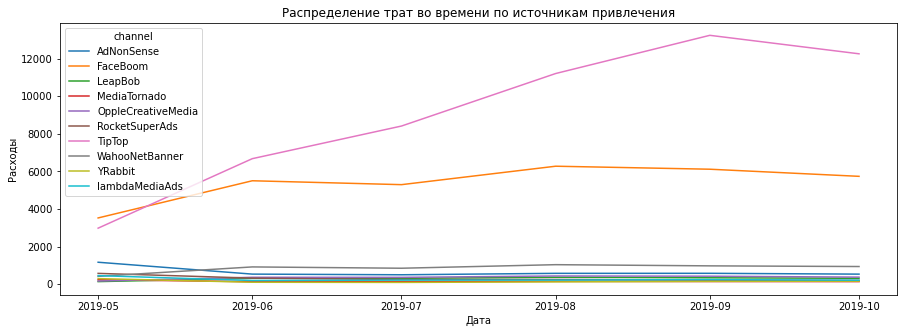

channel,AdNonSense,FaceBoom,LeapBob,MediaTornado,OppleCreativeMedia,RocketSuperAds,TipTop,WahooNetBanner,YRabbit,lambdaMediaAds
costs_month,,,,,,,,,,
2019-05-01,1169.70,3524.4,140.28,238.56,169.75,577.980,2981.0,418.8,299.70,458.4
2019-06-01,538.65,5501.1,314.58,138.00,370.00,325.715,6675.6,921.0,106.20,199.2
2019-07-01,504.00,5294.3,313.53,138.48,366.50,252.070,8410.2,851.4,97.38,219.2
2019-08-01,579.60,6274.4,369.81,154.56,439.25,253.110,11202.0,1040.4,124.74,220.0
2019-09-01,581.70,6114.9,343.98,144.72,427.75,218.400,13232.5,977.4,152.79,247.2
2019-10-01,537.60,5736.5,315.42,140.16,378.00,205.725,12250.0,942.0,163.41,213.6


In [28]:
costs['costs_month'] = costs['dt'].astype('datetime64[M]').dt.date
costs_month = costs.pivot_table(index='costs_month', columns='channel', values='costs', aggfunc='sum')
costs_month.plot(figsize=(15, 5))
plt.xlabel('Дата')
plt.ylabel('Расходы')
plt.title('Распределение трат во времени по источникам привлечения')
plt.show()
costs_month

Рассчитаем средний CAC на одного пользователя для всего проекта.

In [29]:
print('Средний CAC на одного пользователя для всего проекта', round(profiles['acquisition_cost'].mean(), 1))

Средний CAC на одного пользователя для всего проекта 0.7


Рассчитаем средний CAC на одного пользователя для каждого источника трафика.

In [30]:
profiles.sort_values(by='acquisition_cost', ascending = False).head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
146333,975864617797,2019-10-11 08:08:04,TipTop,iPhone,United States,2019-10-11,2019-10-01,False,3.715385
98769,658088125802,2019-10-11 01:59:19,TipTop,iPhone,United States,2019-10-11,2019-10-01,True,3.715385
60726,402874163955,2019-10-11 01:25:37,TipTop,Mac,United States,2019-10-11,2019-10-01,False,3.715385
107727,717904110722,2019-10-11 23:31:06,TipTop,PC,United States,2019-10-11,2019-10-01,False,3.715385
11119,73808119380,2019-10-11 00:23:14,TipTop,Mac,United States,2019-10-11,2019-10-01,False,3.715385


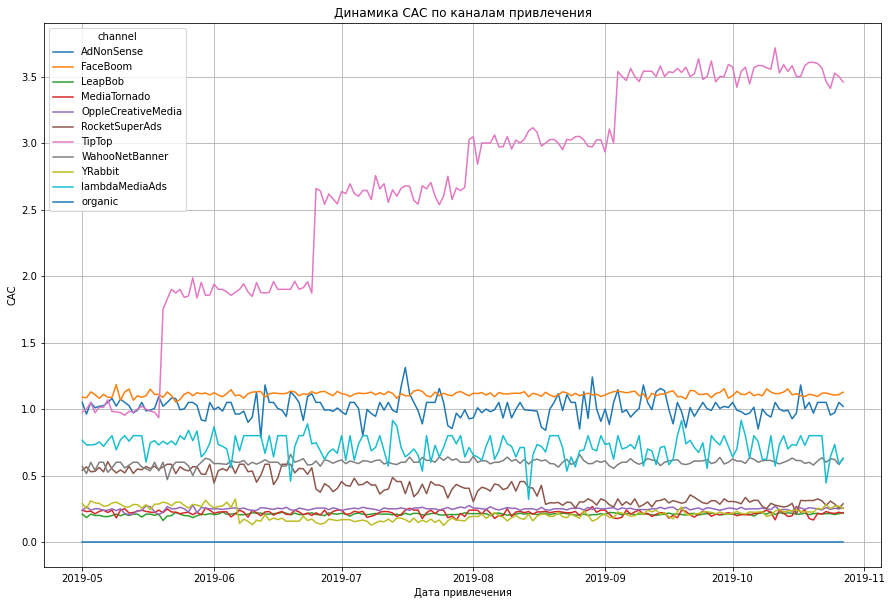

In [31]:
profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(15, 10))
plt.ylabel('CAC')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

**Вывод:**

Из проведенного анализа можно сделать следующие выводы:
* Общая сумма расходов на маркетинг составила 105497.3;
* Самым дорогостоящим источником привлечения стали TipTop и FaceBoom. Это наглядно видно на графике выше. Меньше всего средств было потрачено на YRabbit и MediaTornado;
* Средний CAC на одного пользователя для всего проекта составил 0.7;
* При расчете средний CAC на одного пользователя для каждого источника трафика мы обратили внимание, что CAC для канала TipTop не стабилен, затраты растут ежемесячно. 

# Шаг 6. Оценить окупаемость рекламы для привлечения пользователей

На данном этапе необходимо с помощью LTV и ROI:
- Проанализировать общую окупаемость рекламы;
- Проанализировать окупаемость рекламы с разбивкой по устройствам;
- Проанализировать окупаемость рекламы с разбивкой по странам;
- Проанализировать окупаемость рекламы с разбивкой по рекламным каналам.

Необходимо ответьте на вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости? Изучить конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

При решении этого шага будем считать, что мы смотрите данные 1-го ноября 2019 года и что в организации принято считать, что окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей.

### Проанализируем общую окупаемость рекламы

Для анализа и визуализации общей окупаемости рекламы построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

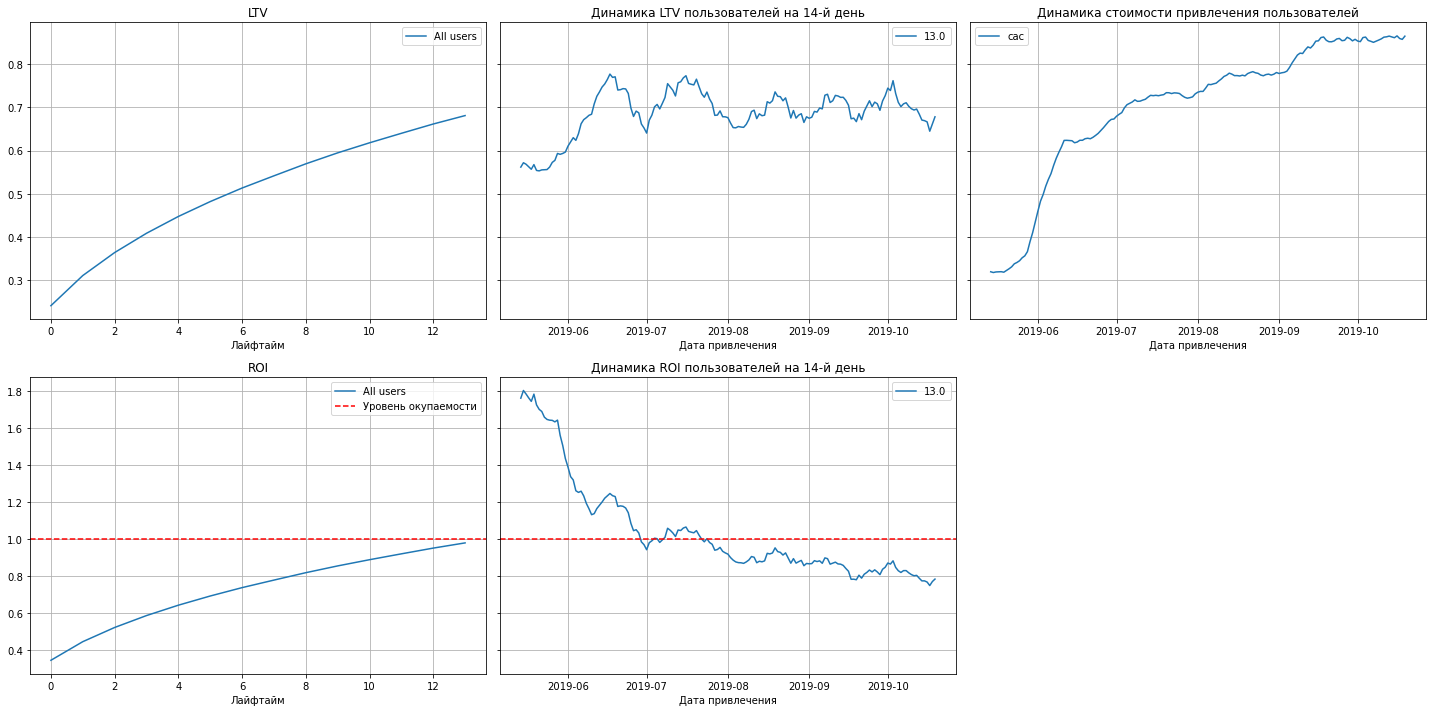

In [32]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)
# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

Из получившихся графиков можно сделать следующие выводы:
* Реклама не окупается. ROI в конце 14 дня только приблизился к 100 %.
* CAC не стабилен. С каждым месяцем стоимость привлечения пользователей растет. 
* Кривая LTV плавно растет. Показатель достаточно стабилен. Значит, дело не в ухудшении качества пользователей. 

### Проанализируем окупаемость рекламы с разбивкой по рекламным каналам

Для анализа и визуализации окупаемости рекламы с разбивкой по рекламным каналам построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

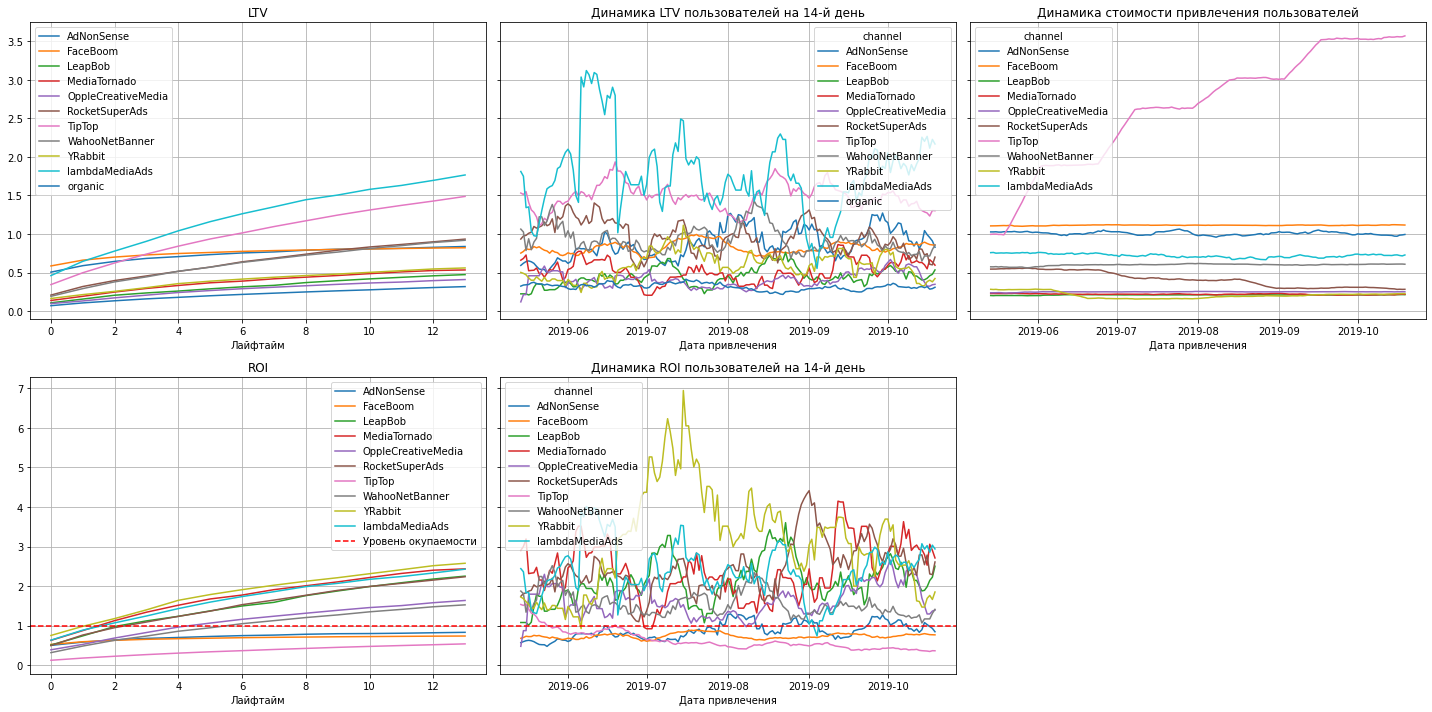

In [33]:
# смотрим окупаемость с разбивкой по рекламным каналам

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Из графика видно следующее:
* Хуже всего окупается рекламная компания TipTop, также аутсайдерами являются FaceBoom и AdNoneSense. Лучшая окупаемость у YRabbit;
* График динамики стоимости привлечения пользователей стабилен для всех рекламных компаний кроме TipTop;
* LTV стабилен.

### Проанализируем окупаемость рекламы с разбивкой по странам

Для анализа и визуализации окупаемость рекламы с разбивкой по странам построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

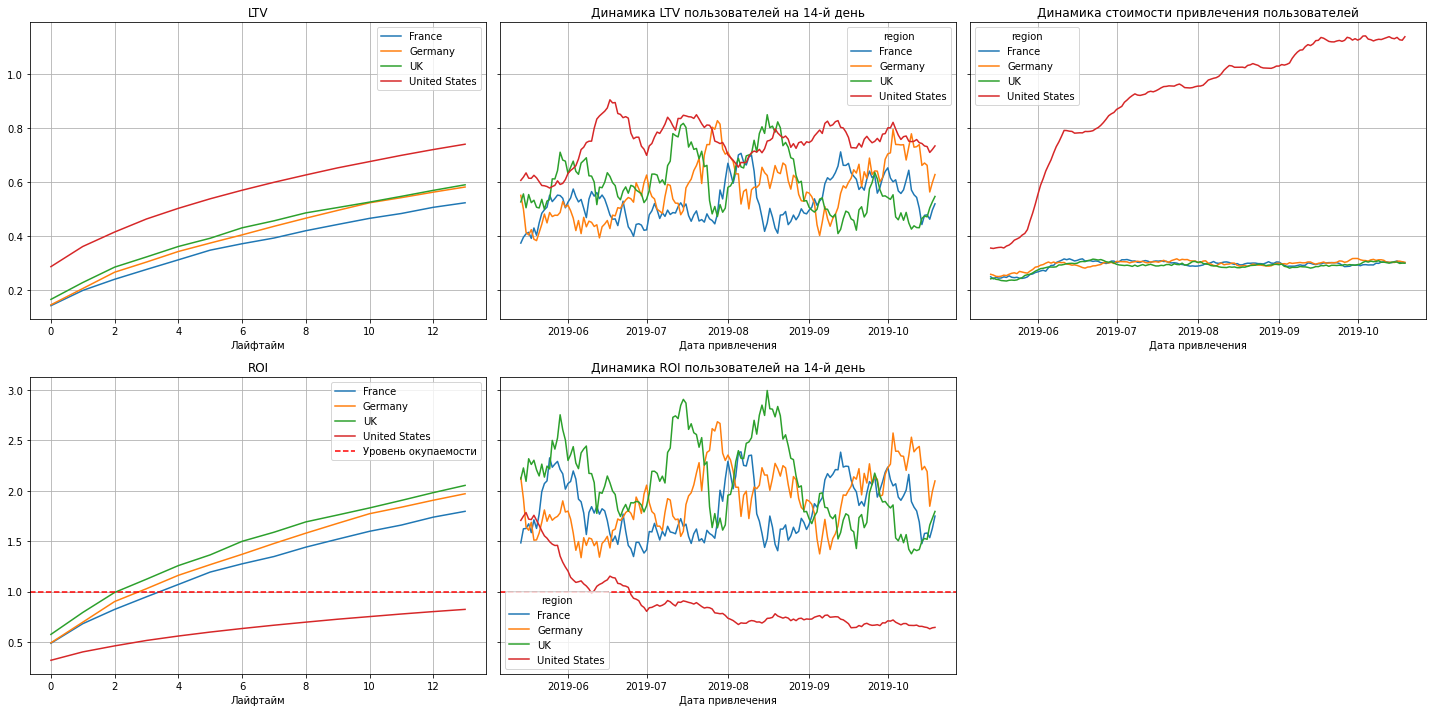

In [34]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

В графиках с разбивкой по странам видно следующее:
* Реклама окупается во Франции, Германии и Великобритании. В Соединенных Штатах ситуация иная, к концу второй неделе показатели только приближаются к уровню окупаемости;
* График динамики стоимости привлечения пользователей аналогичен. Стоимость привлечения стабильна для Франции, Германии и Великобритании. Для Соединенных Штатов ситуация хуже, стоимость ежемесячно повышается;
* LTV стабилен;
* Лучше всего окупается Великобритания;
* Динамика окупаемости инвестиций нестабильна для Соединенных Штатов. Она сильно падает. 

### Проанализируем окупаемость рекламы с разбивкой по устройствам

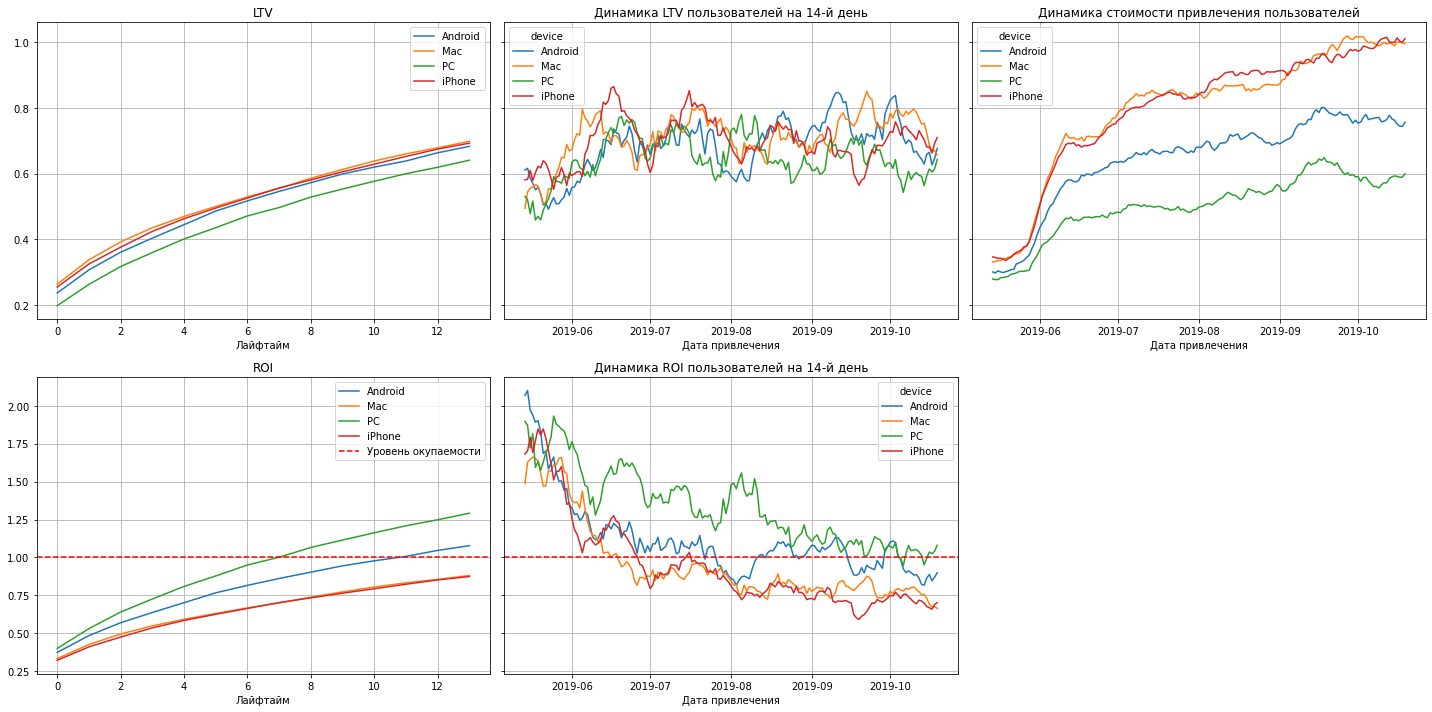

In [35]:
# смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

В графиках с разбивкой по устройствам видно следующее: 
* Пользователи PC и Android стабильно окупаются, а вот владельцы iPhone и Mac — нет.
* Динамика стоимости привлечения растет для всех используемых устройств, но наибольшая стоимость привлечения у пользователей, использующих Mac и iPhone;
* LTV стабилен. 

**Вывод:**

В проведенном анализа мы заметили 2 отрицательных признака:
* Самым дорогостоящим источником привлечения является TipTop, однако он же имеет самые низкие показатели окупаемости инвестиций. 
* Стоимость привлечения пользователей дороже всего на территории Соединенных Штатов. Однако, окупаемость инвестиций ниже всего именно там.
* Пользователи PC и Android стабильно окупаются, а вот владельцы iPhone и Mac — нет. 

### Построим и изучим графики конверсии и удержания с разбивкой по устройствам, странам, рекламным каналам

Посчитаем и визуализируем конверсию с разбивкой по устройствам, вызвав функции get_conversion() и plot_conversion().

Нам известно, что пользователи iPhone и Mac не окупаются. Динамика стоимости привлечения растет для всех используемых устройств, но наибольшая стоимость привлечения у пользователей, использующих Mac и iPhone.

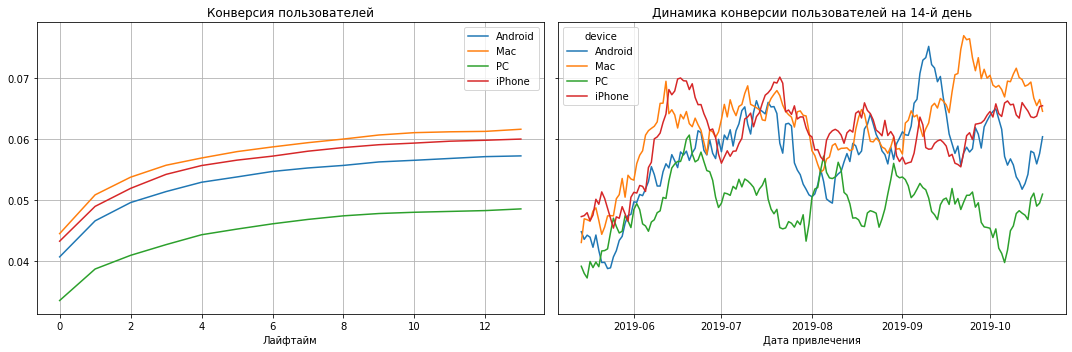

In [36]:
# смотрим конверсию с разбивкой по устройствам

dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Судя по графикам, пользователи Mac и iPhone конвертируются хорошо. Возможно, дело в удержании. Вызовем функции get_retention() и plot_retention(), чтобы рассчитать и отразить на графиках этот показатель.

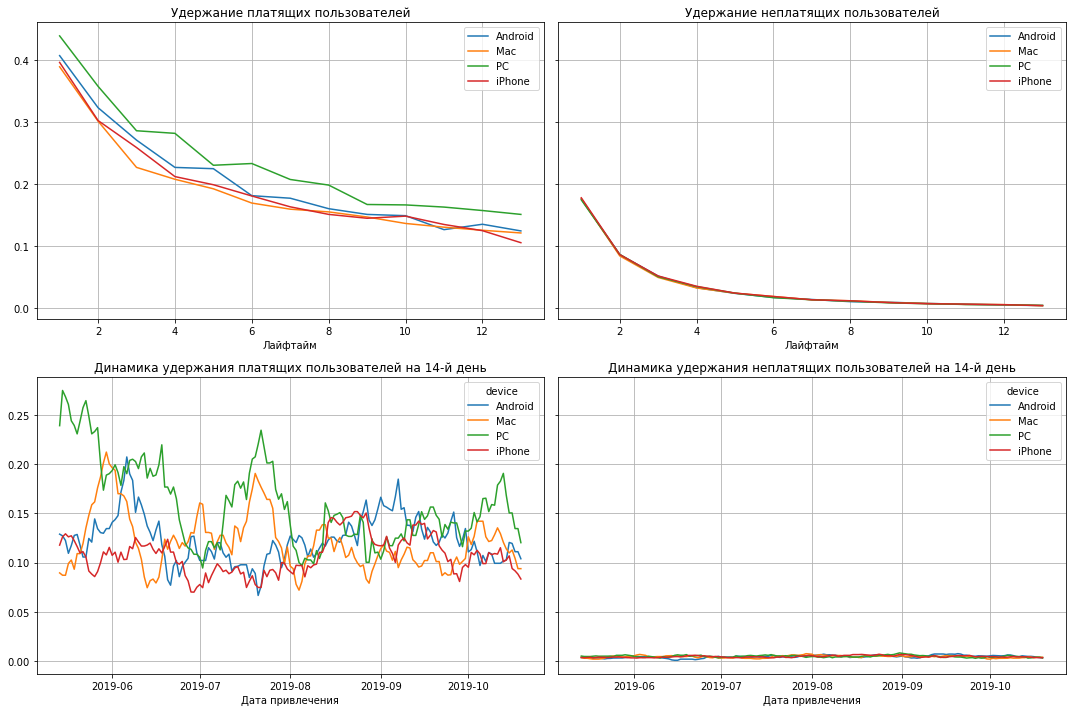

In [37]:
# смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Пользователи iPhone немного хуже удерживаются. 

Посчитаем и визуализируем конверсию с разбивкой по странам, вызвав функции get_conversion() и plot_conversion().

Нам известно, что стоимость привлечения пользователей дороже всего на территории Соединенных Штатов, однако, окупаемость инвестиций ниже всего именно там.

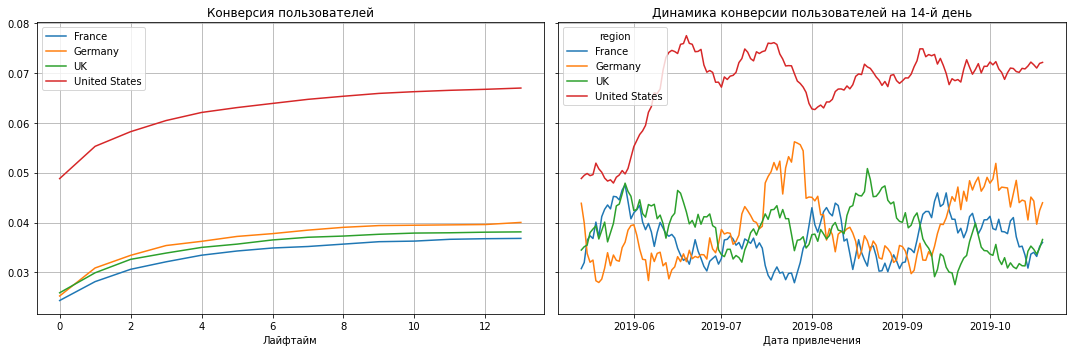

In [38]:
# смотрим конверсию с разбивкой по странам

dimensions = ['region']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Из графика выше видно, что конверсия для Соединенных Штатов хорошая. Проверим что происходит с удержанием клиентов. Вызовем функции get_retention() и plot_retention(). 

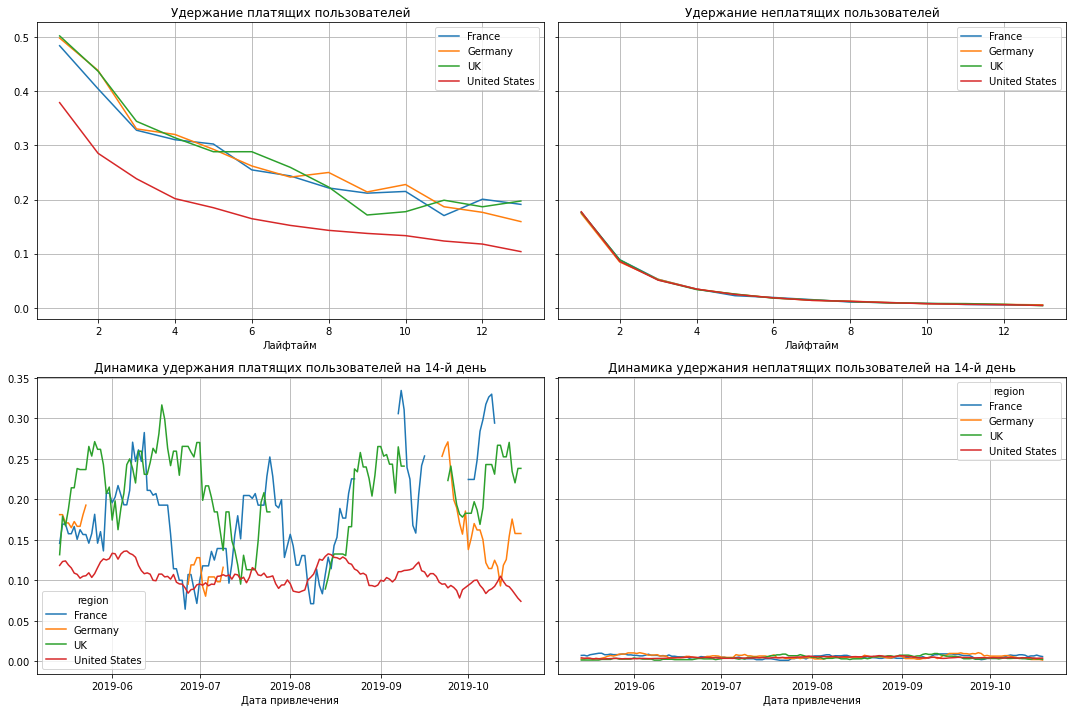

In [39]:
# смотрим удержание с разбивкой по странам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

График подтвердил наши ожидания. Пользователи из Соединенных Штатов удерживаются хуже остальных. 

Посчитаем и визуализируем конверсию с разбивкой по рекламным каналам, вызвав функции get_conversion() и plot_conversion().

Нам известно, что самым дорогостоящим источником привлечения является TipTop, FaceBoom и AdNoneSense. Также, TipTop имеет самые низкие показатели окупаемости инвестиций.

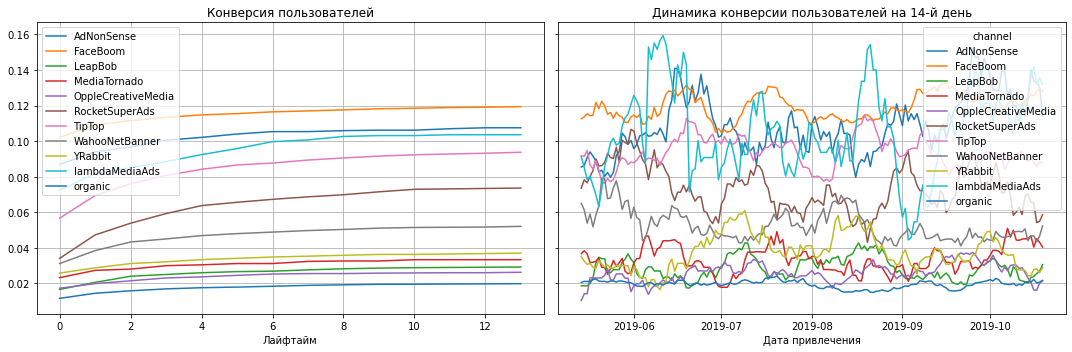

In [40]:
# смотрим конверсию с разбивкой по рекламным каналам

dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

График показал, что конверсия для рекламного канала TipTop, FaceBoom и AdNoneSense хорошая. Необходимо проверить удержанием клиентов, возможно причина в этом. Вызовем функции get_retention() и plot_retention().

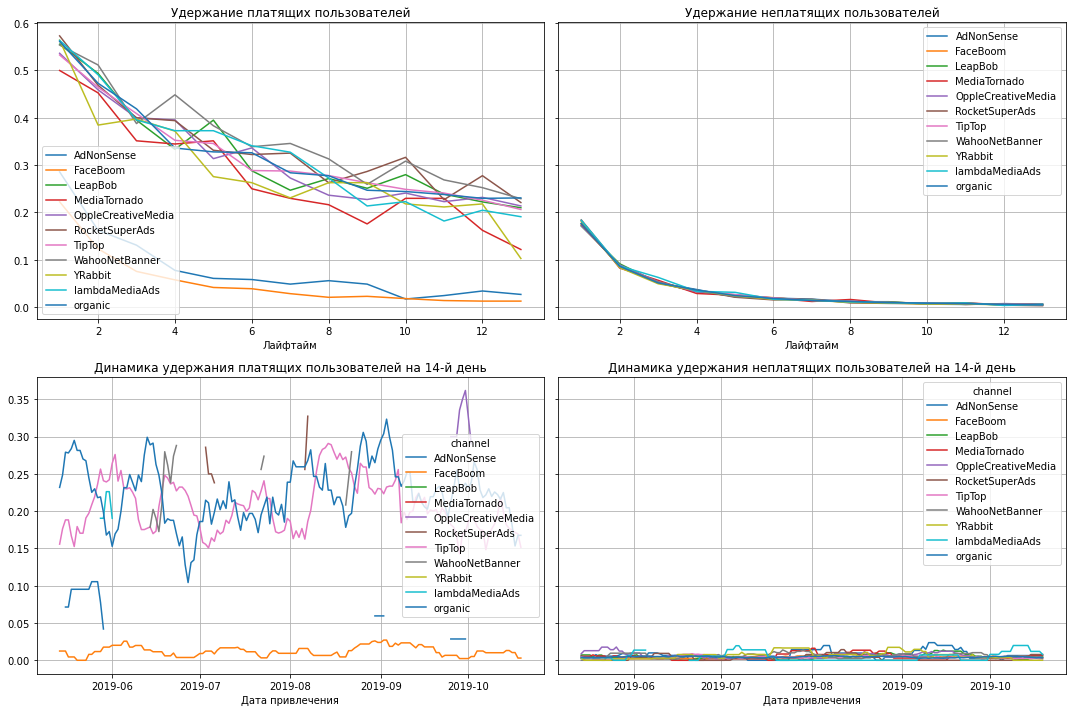

In [41]:
# смотрим удержание с разбивкой по рекламным каналам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

График подтвердил наше предположение. Динамика удержания платящих пользователей хуже всего у FaceBoom, AdNoneSense и TipTop. 

Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Мы провели анализ окупаемости рекламы и можем сделать следующие **выводы**:

Реклама не окупается в достаточном размере. Есть нюансы, на которые стоит обратить внимание для снижения стоимости и большей эффективности. Мы выяснили какие устройства, страны и каналы могут снижать окупаемость рекламы:
* В Соединенных Штатах плохо удерживаются пользователи;
* Из рекламных каналов FaceBoom, AdNoneSense и TipTop также плохо удерживаются пользователи;
* Стоимость привлечения пользователей устройств iPhone и Mac выше, но при этом у них нет проблем с конверсией и удержанием. 

# Шаг 7. Общий вывод

В наше распоряжение попали данные развлекательного приложения Procrastinate Pro+. Компания вкладывает огромные вложения в рекламу, однако последние несколько месяцев компания терпит убытки. Наша задача была — разобраться в причинах и помочь компании выйти в плюс.

Мы обработали данных, изменили типы данных и названия колонок. Был проведен исследовательский анализ, посчитаны расходы на маркетинг и проведена оцените окупаемость рекламы. 

Рекомендации для отдела маркетинга: 
* Стоит рассмотреть вариант отказа или замены некоторых каналов привлечения. К примеру, отказаться от рекламных каналов FaceBoom, AdNoneSense и TipTop в пользу более продуктивных. 
* Найти варианты менее дорогостоящего способа привлечения пользователей устройств iPhone и Mac. 
* Придумать как увеличить удерживание пользователей Соединенных Штатов. 

В качестве общей рекомендации: направить бюджеты из "неудачных" каналов в "удачные".